# Segment Anything on LiDAR data


In [26]:
from segment_lidar import samlidar, view
import matplotlib.pyplot as plt
from sklearn import cluster, neural_network, mixture, tree, ensemble
from math import floor
import numpy as np
import cv2 as cv

## Initialize the Segment Anything Model

- **ckpt_path:** The path to the model checkpoint.
- **model_type:** The model type to use according the checkpoint.
- **resolution:** The resolution of the LiDAR points to generate the raster.


In [2]:
viewpoint = view.TopView()
model = samlidar.SamLidar(
    ckpt_path="/mnt/Poznan_Internship/sam_vit_h_4b8939.pth",
    model_type="vit_h"
)

## Read from a Point Cloud data file (.las, .laz)


In [3]:
points = model.read("/mnt/Poznan_Internship/Data/CampusTmp/cloud2853085222bfe35e_Block_4.las")

Reading /mnt/Poznan_Internship/Data/CampusTmp/cloud2853085222bfe35e_Block_4.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 1.12 seconds. The point cloud contains 16371670 points.



In [104]:
# cloud, non_ground, ground = model.csf(points, class_threshold=0.1)

In [4]:
labels, segment_image, image = model.segment(points=points, view=viewpoint, image_path="./raster.tif", labels_path="./labeled.tif")
# model.write(points=cloud, non_ground=non_ground, ground=ground, segment_ids=labels, save_path="segmented.las")

- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 229.85 seconds. Number of instances: 660



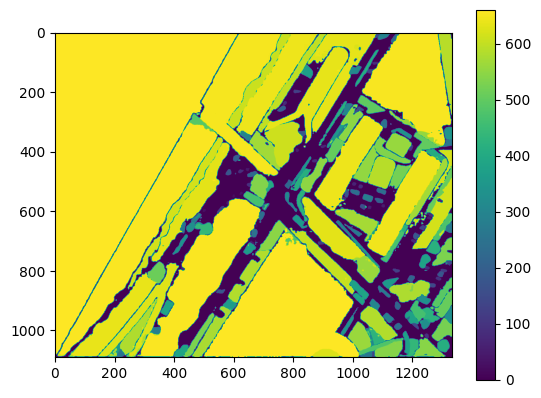

In [5]:
im = plt.imshow(segment_image)
plt.colorbar(im)

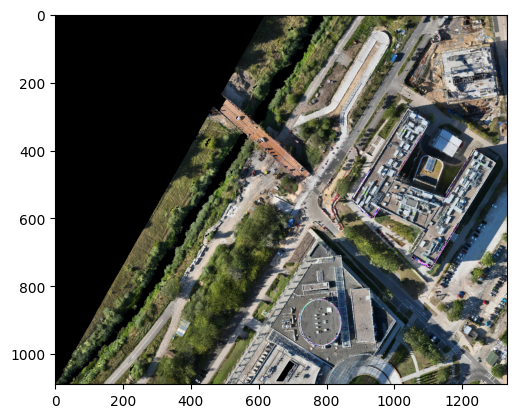

In [6]:
im = plt.imshow(image.transpose(1, 2, 0))

In [7]:
image = image.transpose((1, 2 ,0))

In [8]:
labels = np.unique(segment_image)

In [9]:
segments_img = dict()
filter_size = 1000

for l in labels:
    if l == 0:
        continue
    mask = np.zeros(image.shape, dtype=int)
    mask[segment_image == l] = [1, 1, 1]
    result = image * mask
    seg = np.argwhere(result)
    if not seg.shape[0] or not seg.shape[1]:
        continue
    if np.sum(seg.shape[:1]) < filter_size:
        continue

    minx, maxx = np.min(seg[:, 0]), np.max(seg[:, 0])
    miny, maxy = np.min(seg[:, 1]), np.max(seg[:, 1])
    segments_img.update({l: result[minx:maxx + 1, miny:maxy + 1]})

In [10]:
def resize_image(a: np.ndarray, size: tuple, preserve_aspect_ratio: bool = True, debug: bool = False):
    assert len(a.shape) == 3, "input matrix should have a shape HxWx3"
    assert a.shape[-1] == 3, "input matrix should be a 3 channels image"

    (height, width, _) = a.shape

    (output_height, output_width) = size
    assert  output_height > 0 and output_width > 0

    aspect_ratio = 1.0
    if preserve_aspect_ratio:
        aspect_ratio = float(width) / float(height)
    
    (adjusted_height, adjusted_width) = size
    if aspect_ratio > 1.0:
        adjusted_height = int(output_height * (aspect_ratio - 1))
    elif aspect_ratio < 1.0:
        adjusted_width = int(output_width * aspect_ratio)
    
    offset_x, offset_y = floor(abs(output_width - adjusted_width) / 2), floor(abs(output_height - adjusted_height) / 2)
    assert offset_x >= 0 and offset_y >= 0, "offset_x and offset_y should be equal or greater than zero"
    
    if debug:
        print(f"Input:\theight={height} width={width} (ratio: {aspect_ratio})")
        print(f"Adj:\theight={adjusted_height} width={adjusted_width}")
        print(f"Output:\theight={output_height} width={output_width}")
        print(f"Offset:\tx={offset_x} y={offset_y}")

    result = cv.resize(a.astype('float32'), (adjusted_width, adjusted_height), interpolation=cv.INTER_NEAREST).astype(int)
    result = np.pad(result, [(offset_y, offset_y), (offset_x, offset_x), (0, 0)], mode="constant")

    # Because of round values we can get errors between 1 and -1 pixels
    if result.shape[0] != output_height:
        delta = abs(result.shape[0] - output_height)
        result = np.pad(result, [(0, delta), (0, 0), (0, 0)], mode="constant")
    if result.shape[1] != output_width:
        delta = abs(result.shape[1] - output_width)
        result = np.pad(result, [(0, 0), (0, delta), (0, 0)], mode="constant")
    
    assert result.shape[:-1] == size, "output should match expected size"
    
    return result.astype(np.double)

# Use Decision Tree to classify the clusters


In [21]:
MAPPING_FILE = "./train/mapping.txt"
CLASSES_FILE = "./train/classes.txt"
IMAGES_PATH = "./train/images"
INPUT_SIZE = (64, 64)

In [22]:
classes = None
with open(CLASSES_FILE, "r") as cf:
    nb_classes = len(cf.readlines())
    classes = np.diag((nb_classes, nb_classes)) / nb_classes

In [23]:
x = []
y = []
with open(MAPPING_FILE, "r") as mf:
    annotations = mf.readlines()
    nb_images = len(annotations)
    for i in range(0, nb_images):
        [img_name, classe] = annotations[i].split(" ")
        img = resize_image(cv.imread(f"{IMAGES_PATH}/{img_name}"), INPUT_SIZE, False)
        x.append([
            np.mean(img[:, :, 0]),
            np.mean(img[:, :, 1]),
            np.mean(img[:, :, 2])
        ])
        y.append(int(classe.replace("\n", "")))

In [38]:
model = tree.DecisionTreeClassifier()
model.fit(x, y)

DecisionTreeClassifier()

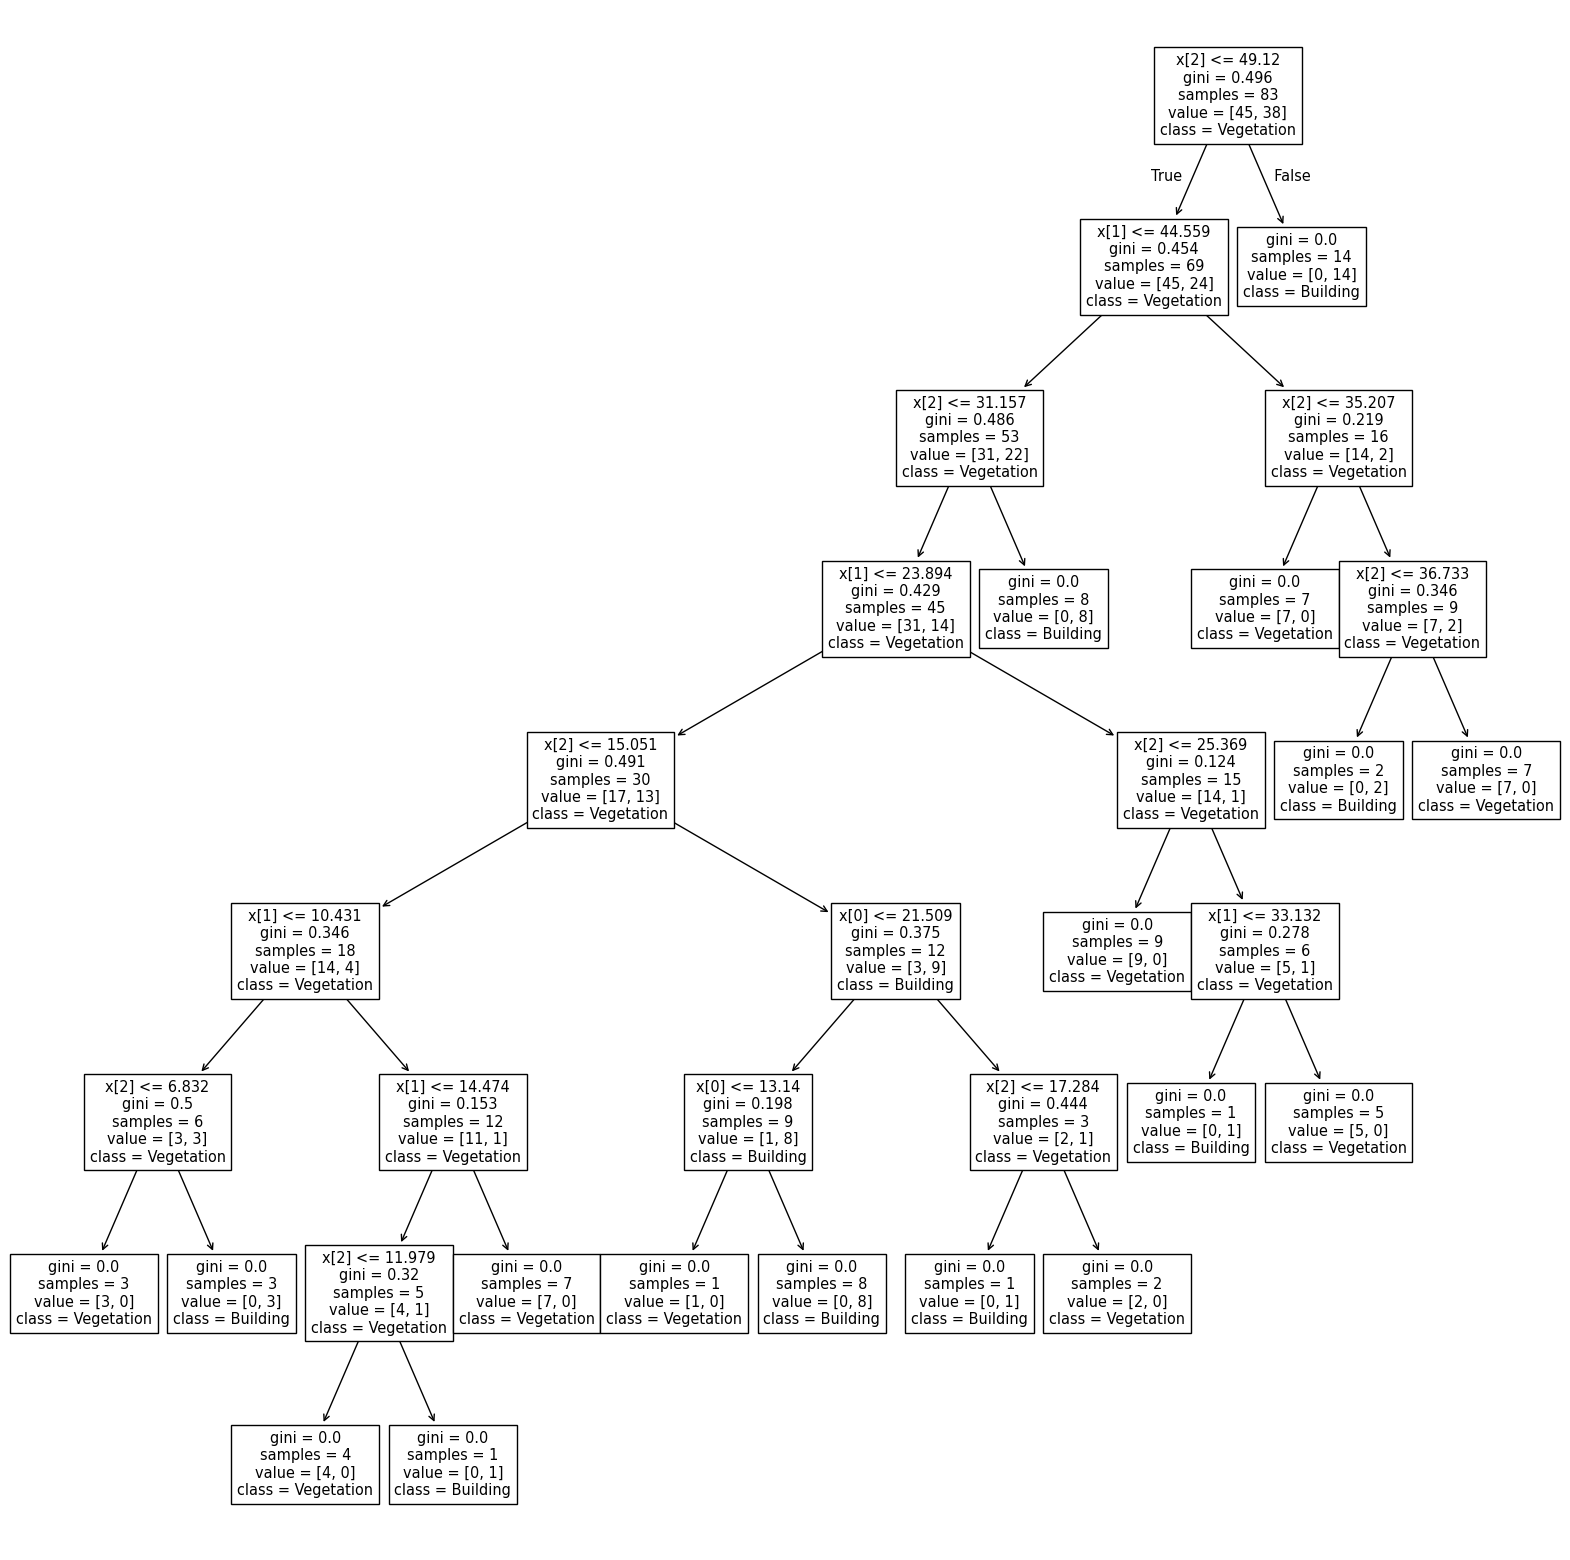

In [39]:
plt.figure(figsize=(20, 20))
tree.plot_tree(model, class_names=["Vegetation", "Building"])
plt.show()

In [40]:
buildings = []
vegetations = []
for segment, img in segments_img.items():
    kind = "Building" if model.predict([[np.mean(img[:, :, 0]), np.mean(img[:, :, 1]), np.mean(img[:, :, 2])]]) else "Vegetation"
    if kind == "Building":
        buildings.append(segment)
    else:
        vegetations.append(segment)
print(buildings)

[202, 205, 208, 219, 220, 223, 225, 229, 239, 240, 242, 250, 254, 261, 268, 270, 271, 273, 283, 286, 290, 294, 296, 297, 298, 300, 303, 311, 324, 330, 338, 348, 354, 357, 362, 366, 369, 377, 378, 379, 381, 385, 387, 389, 421, 422, 424, 427, 437, 440, 465, 467, 476, 479, 484, 499, 502, 504, 507, 525, 529, 530, 535, 537, 542, 559, 560, 568, 589, 590, 599, 636, 644, 646, 654, 659]


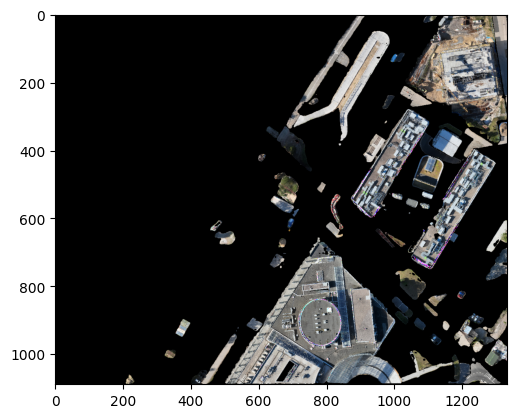

In [41]:
mask = np.zeros(image.shape, dtype=int)
for b in buildings:
    mask[segment_image == b] = [1, 1, 1]
plt.imshow(image * mask)

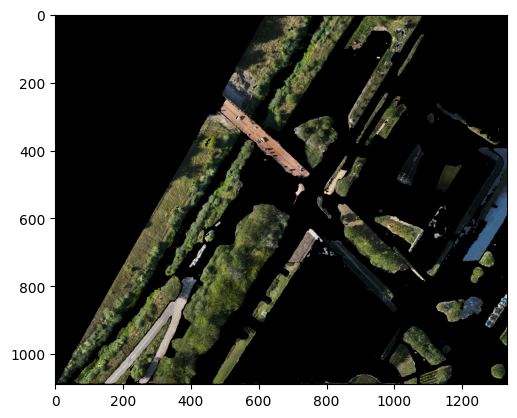

In [42]:
mask = np.zeros(image.shape, dtype=int)
for b in vegetations:
    mask[segment_image == b] = [1, 1, 1]
plt.imshow(image * mask)